In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import logging
import os

import matplotlib.pyplot as plt

import core.config as cconfig
import core.plotting as coplotti
import core.statistics as costatis
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hparquet as hparque
import helpers.hprint as hprint

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-de8c6404-02fa-4dc5-8be5-764cf5d6d46a.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.3' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4692_Adapt_regression_function_to_common_workflows'
  hash='851bcee19'
  # Last commits:
    *   851bcee19 paul     Merge branch 'master' into CmTask4692_Adapt_regression_function_to_common_workflows (12 minutes ago) Tue Jul 11 14:45:36 2023  (HEAD -> CmTask4692_Adapt_regression_function_to_common_workflows, origin/CmTask4692_Adapt_regression_function_to_common_workflows)
    |\  
    * | 0657ff9b1 paul     Fix logging

# Build config

In [4]:
amp_dir = hgit.get_amp_abs_path()
dir_name = os.path.join(
    amp_dir,
    "dataflow/model/test/outcomes/Test_run_master_feature_analyzer/input/tiled_results",
)
cols = [
    "vwap.ret_0.vol_adj.c.lag0",
    "vwap.ret_0.vol_adj.c.lag1",
    "vwap.ret_0.vol_adj.c.lag2",
    "vwap.ret_0.vol_adj.c.lag3",
]
config = {
    "dir_name": dir_name,
    "asset_id": 1467591036,
    "asset_id_col": "asset_id",
    "resampling_frequency": "5T",
    "feature_column_names": cols,
    "single_feature_column_name": "vwap.ret_0.vol_adj.c.lag0",
    "regression_config": {
        "x_cols": cols,
        "y_col": "vwap.ret_0.vol_adj.c.lag0",
        "x_col_shift": 2,
    },
}
config = cconfig.Config().from_dict(config)
print(config)

ERROR While executing 'get_extra_amp_repo_sym_name()' caught error:
name 'get_extra_amp_repo_sym_name' is not defined
Trying to continue
dir_name: /app/amp/dataflow/model/test/outcomes/Test_run_master_feature_analyzer/input/tiled_results
asset_id: 1467591036
asset_id_col: asset_id
resampling_frequency: 5T
feature_column_names: ['vwap.ret_0.vol_adj.c.lag0', 'vwap.ret_0.vol_adj.c.lag1', 'vwap.ret_0.vol_adj.c.lag2', 'vwap.ret_0.vol_adj.c.lag3']
single_feature_column_name: vwap.ret_0.vol_adj.c.lag0
regression_config: 
  x_cols: ['vwap.ret_0.vol_adj.c.lag0', 'vwap.ret_0.vol_adj.c.lag1', 'vwap.ret_0.vol_adj.c.lag2', 'vwap.ret_0.vol_adj.c.lag3']
  y_col: vwap.ret_0.vol_adj.c.lag0
  x_col_shift: 2


# Report tile metadata

In [5]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    config["dir_name"]
)

In [6]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1467591036,1,1,1,12.4 KB
3303714233,1,1,1,12.4 KB


In [7]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

,,n_asset_ids,size
year,month,,
2000,1,2,24.8 KB


In [8]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1467591036, 3303714233]

# Load features

In [9]:
asset_batch_size = len(asset_ids)
# Add the `asset_id_col` to also display the instruments. This is also required
# to make `yield_parquet_tiles_by_assets()` work.
requested_columns = [config["asset_id_col"]] + config["feature_column_names"]
tile_iter = hparque.yield_parquet_tiles_by_assets(
    config["dir_name"], asset_ids, config["asset_id_col"], asset_batch_size, None
)

In [10]:
tile = next(tile_iter)

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
feature_df = dtfmod.process_parquet_read_df(
    tile[config["feature_column_names"] + [config["asset_id_col"]]],
    config["asset_id_col"],
)

In [12]:
feature_df.columns.levels[0].to_list()

['vwap.ret_0.vol_adj.c.lag0',
 'vwap.ret_0.vol_adj.c.lag1',
 'vwap.ret_0.vol_adj.c.lag2',
 'vwap.ret_0.vol_adj.c.lag3']

In [13]:
feature_stats = costatis.compute_centered_process_stats_by_group(feature_df)
display(feature_stats.head())

Processing groups:   0%|          | 0/2 [00:00<?, ?it/s]

count  eff_count      mean       var  autocovar  autocorr      turn
1467591036 vwap.ret_0.vol_adj.c.lag0     27       27.0 -0.036284  0.959762  -0.924216 -0.962963  1.981395
           vwap.ret_0.vol_adj.c.lag1     26       26.0  0.000000  0.959762  -0.922848 -0.961538  1.980676
           vwap.ret_0.vol_adj.c.lag2     25       25.0 -0.039187  0.959762  -0.921372 -0.960000  1.979899
           vwap.ret_0.vol_adj.c.lag3     24       24.0  0.000000  0.959762  -0.919772 -0.958333  1.979057
3303714233 vwap.ret_0.vol_adj.c.lag0     27       27.0 -0.036284  0.959762  -0.924216 -0.962963  1.981395

In [14]:
feature_stats.groupby(level=1).mean()

,count,eff_count,mean,var,autocovar,autocorr,turn
vwap.ret_0.vol_adj.c.lag0,27.0,27.0,-0.036284,0.959762,-0.924216,-0.962963,1.981395
vwap.ret_0.vol_adj.c.lag1,26.0,26.0,0.000000,0.959762,-0.922848,-0.961538,1.980676
vwap.ret_0.vol_adj.c.lag2,25.0,25.0,-0.039187,0.959762,-0.921372,-0.960000,1.979899
vwap.ret_0.vol_adj.c.lag3,24.0,24.0,0.000000,0.959762,-0.919772,-0.958333,1.979057


In [15]:
feature_stats.groupby(level=0).mean()

,count,eff_count,mean,var,autocovar,autocorr,turn
1467591036,25.5,25.5,-0.018868,0.959762,-0.922052,-0.960709,1.980257
3303714233,25.5,25.5,-0.018868,0.959762,-0.922052,-0.960709,1.980257


In [16]:
feature_stats = costatis.compute_centered_process_stats_by_group(feature_df)
display(feature_stats.head())

Processing groups:   0%|          | 0/2 [00:00<?, ?it/s]

count  eff_count      mean       var  autocovar  autocorr      turn
1467591036 vwap.ret_0.vol_adj.c.lag0     27       27.0 -0.036284  0.959762  -0.924216 -0.962963  1.981395
           vwap.ret_0.vol_adj.c.lag1     26       26.0  0.000000  0.959762  -0.922848 -0.961538  1.980676
           vwap.ret_0.vol_adj.c.lag2     25       25.0 -0.039187  0.959762  -0.921372 -0.960000  1.979899
           vwap.ret_0.vol_adj.c.lag3     24       24.0  0.000000  0.959762  -0.919772 -0.958333  1.979057
3303714233 vwap.ret_0.vol_adj.c.lag0     27       27.0 -0.036284  0.959762  -0.924216 -0.962963  1.981395

In [17]:
mean_asset_stats_per_feature = feature_stats.groupby(level=1).mean()
display(mean_asset_stats_per_feature)

,count,eff_count,mean,var,autocovar,autocorr,turn
vwap.ret_0.vol_adj.c.lag0,27.0,27.0,-0.036284,0.959762,-0.924216,-0.962963,1.981395
vwap.ret_0.vol_adj.c.lag1,26.0,26.0,0.000000,0.959762,-0.922848,-0.961538,1.980676
vwap.ret_0.vol_adj.c.lag2,25.0,25.0,-0.039187,0.959762,-0.921372,-0.960000,1.979899
vwap.ret_0.vol_adj.c.lag3,24.0,24.0,0.000000,0.959762,-0.919772,-0.958333,1.979057


<AxesSubplot: ylabel='mean asset per feature'>

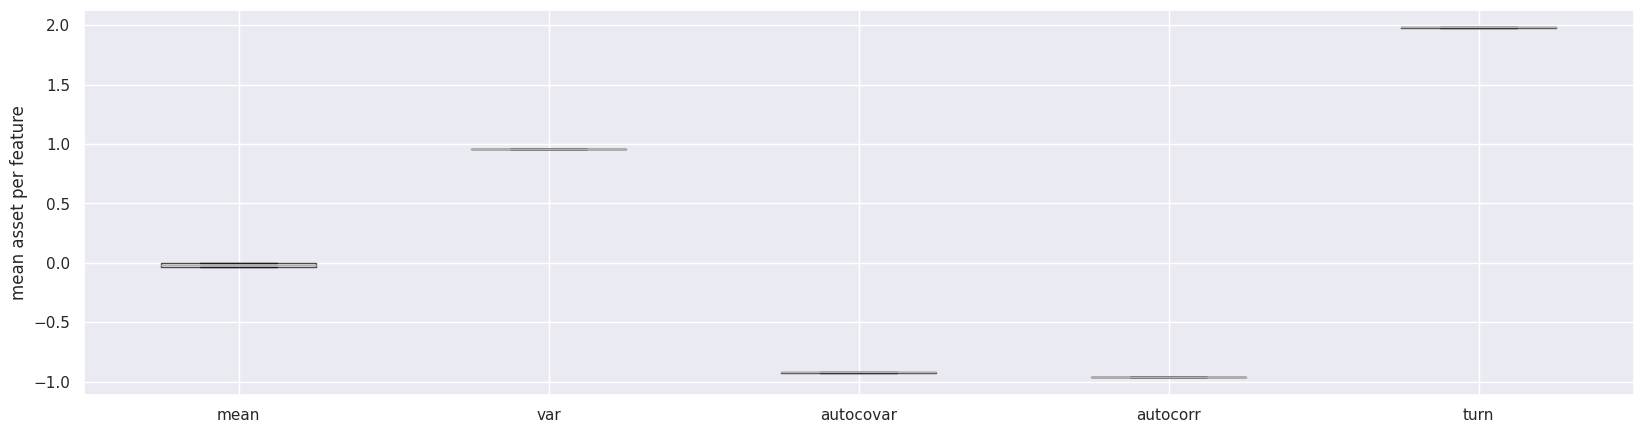

In [18]:
_, ax = plt.subplots()
mean_asset_stats_per_feature[
    ["mean", "var", "autocovar", "autocorr", "turn"]
].boxplot(ylabel="mean asset per feature", ax=ax)

In [19]:
mean_feature_stats_per_asset = feature_stats.groupby(level=0).mean()
display(mean_feature_stats_per_asset)

,count,eff_count,mean,var,autocovar,autocorr,turn
1467591036,25.5,25.5,-0.018868,0.959762,-0.922052,-0.960709,1.980257
3303714233,25.5,25.5,-0.018868,0.959762,-0.922052,-0.960709,1.980257


<AxesSubplot: ylabel='mean feature per asset'>

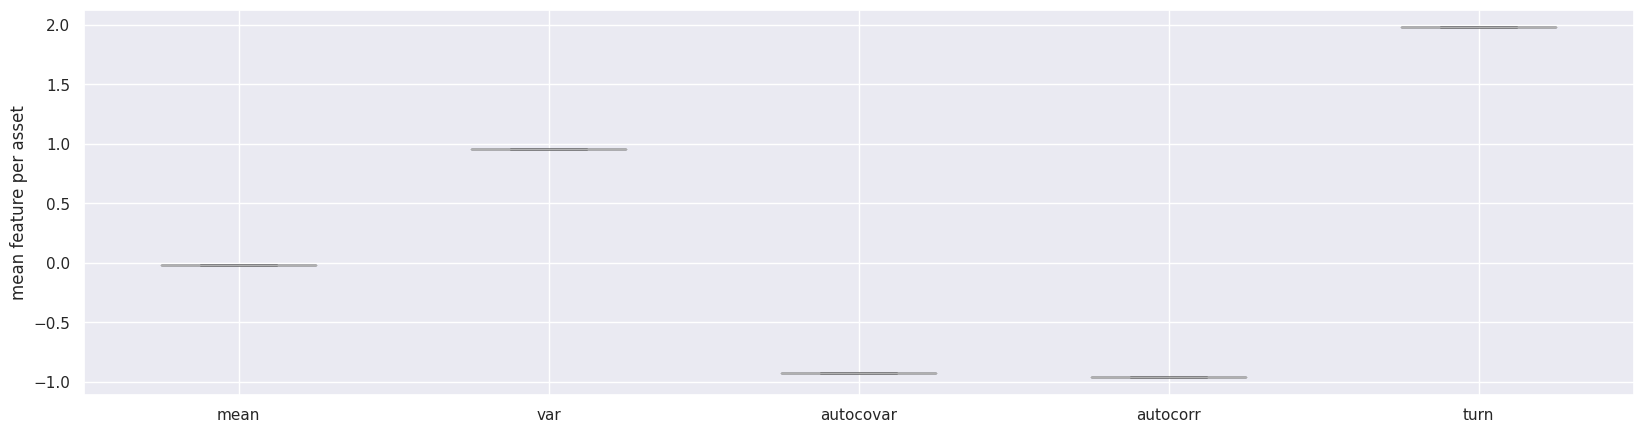

In [20]:
_, ax = plt.subplots()
mean_feature_stats_per_asset[
    ["mean", "var", "autocovar", "autocorr", "turn"]
].boxplot(ylabel="mean feature per asset", ax=ax)

/venv/lib/python3.8/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


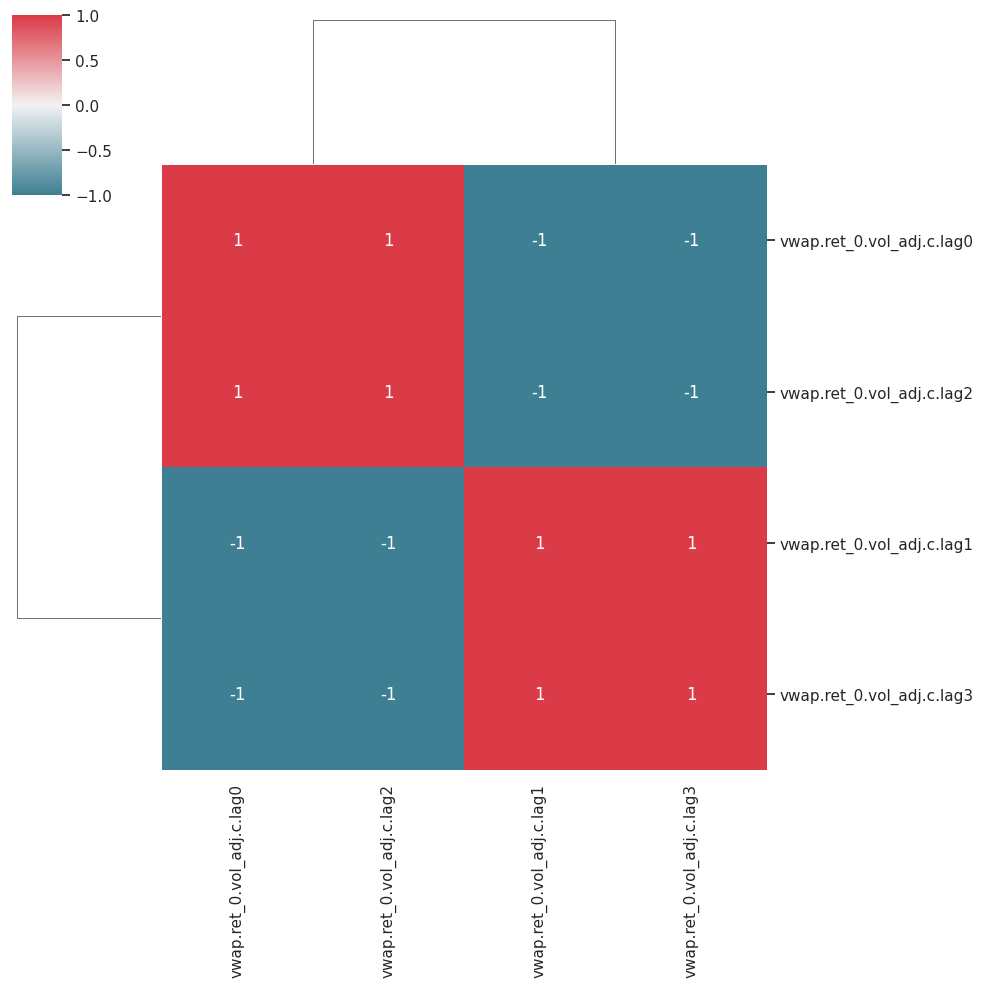

In [21]:
mean_feature_corr = costatis.compute_mean_pearson_correlation_by_group(
    feature_df, 1
)
coplotti.plot_heatmap(mean_feature_corr, mode="clustermap", figsize=(10, 10))

/venv/lib/python3.8/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/venv/lib/python3.8/site-packages/seaborn/matrix.py:615: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)
/venv/lib/python3.8/site-packages/seaborn/matrix.py:623: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


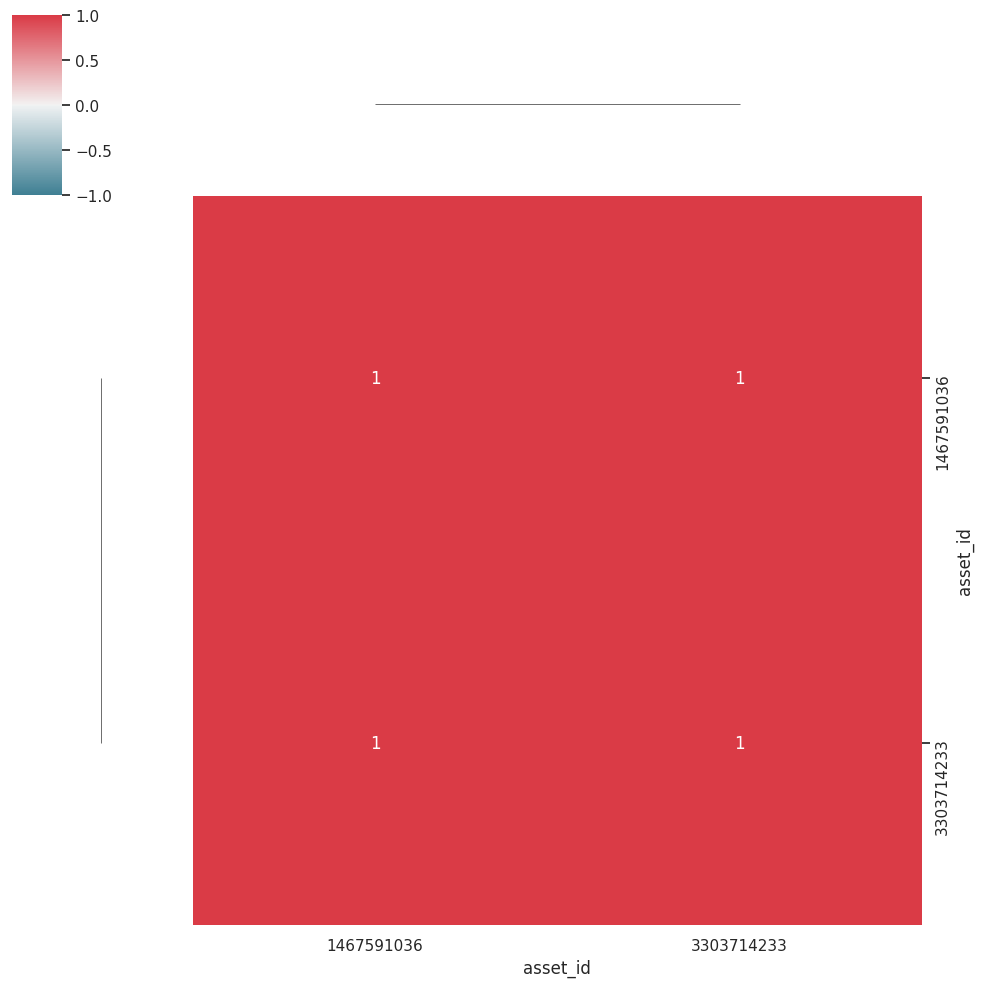

In [22]:
mean_asset_corr = costatis.compute_mean_pearson_correlation_by_group(
    feature_df, 0
)
coplotti.plot_heatmap(mean_asset_corr, mode="clustermap", figsize=(10, 10))

# Per-asset cross-sectional feature analysis (all features for a single asset)

In [23]:
single_asset_feature_df = feature_df.T.xs(config["asset_id"], level=1).T

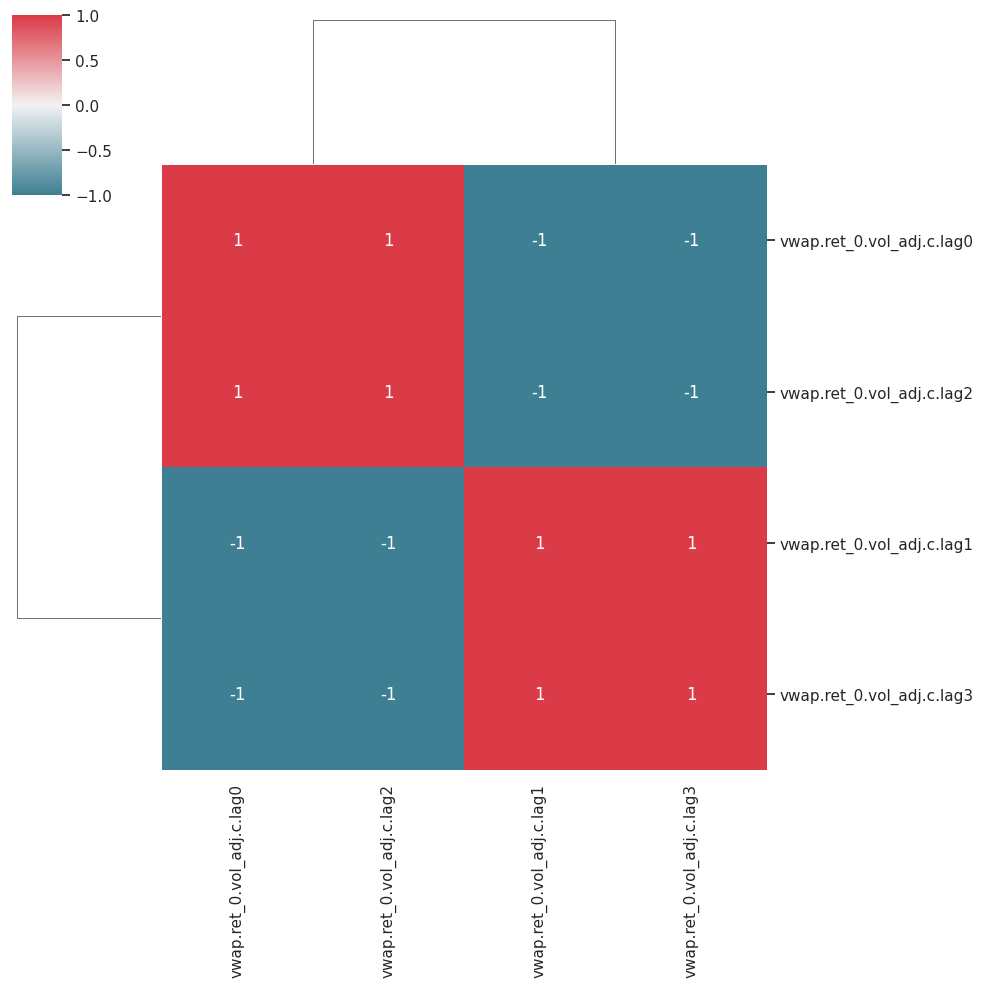

In [24]:
coplotti.plot_heatmap(
    single_asset_feature_df.corr(), mode="clustermap", figsize=(10, 10)
)
# Alternative method (prints correlation matrix and does not reorder columns):
# coplotti.plot_correlation_matrix(features)

[1.0000000000000104, 1.0000000000000004, 1.0000000000000002]

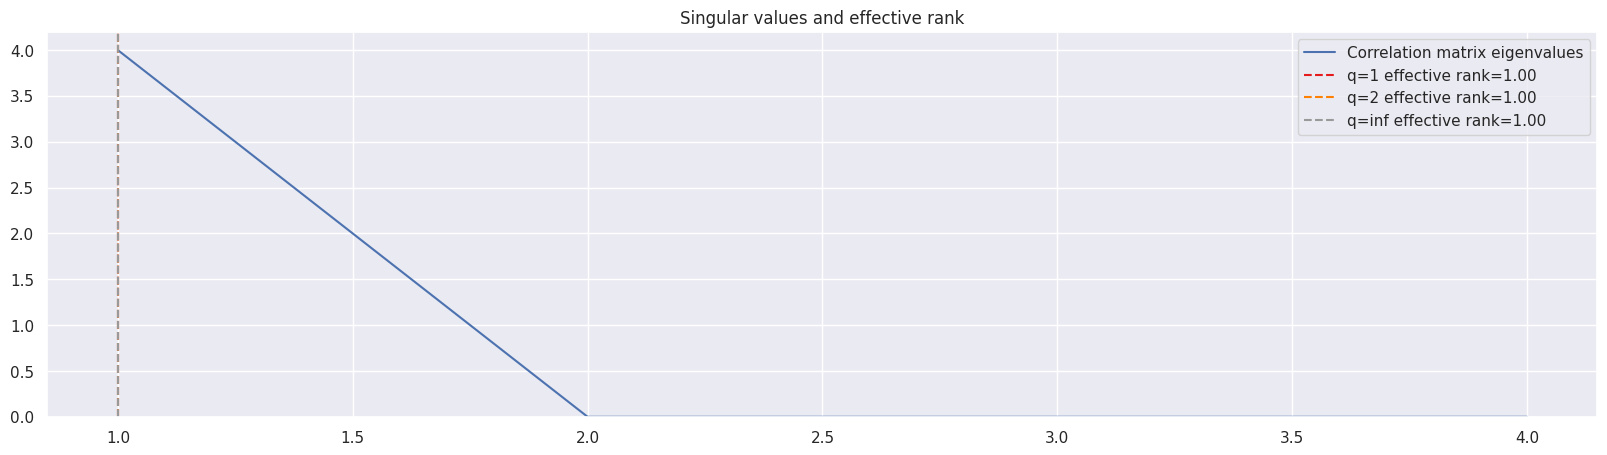

In [25]:
coplotti.plot_effective_correlation_rank(single_asset_feature_df)

/app/amp/core/plotting/misc_plotting.py:202: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  range_df.iloc[:, i] = i


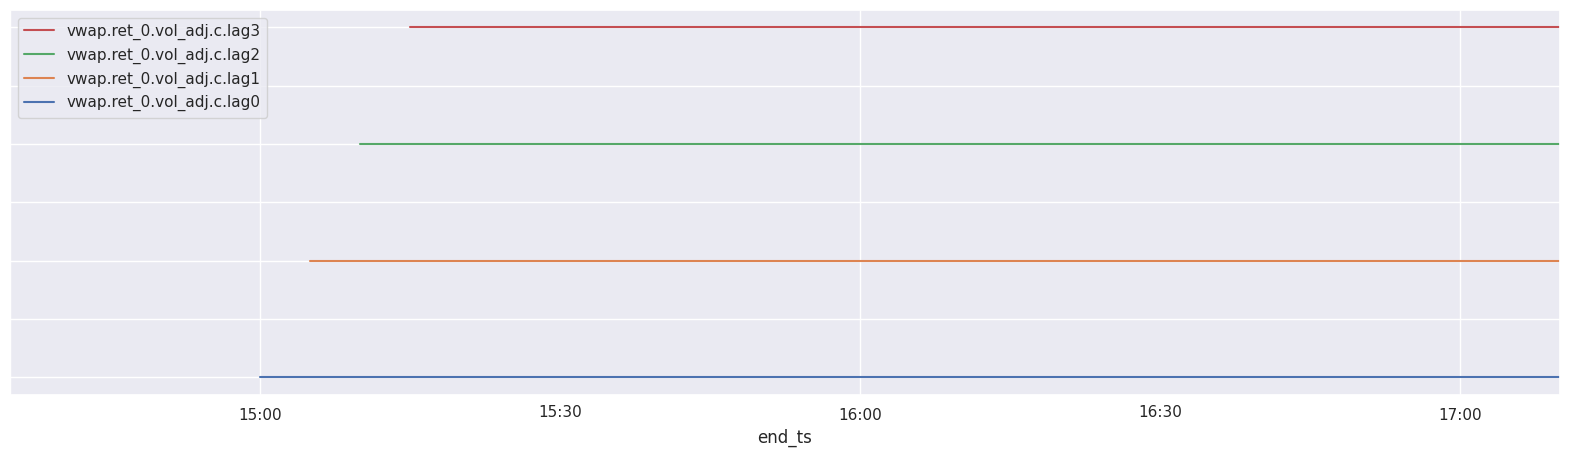

In [26]:
coplotti.plot_projection(
    single_asset_feature_df.resample(config["resampling_frequency"]).sum(
        min_count=1
    )
)

In [27]:
# sc = dtfmod.StatsComputer()
# single_asset_feature_df.apply(sc.compute_summary_stats).round(3)
# Alternative method:
single_asset_feature_df.apply(costatis.compute_moments)

,vwap.ret_0.vol_adj.c.lag0,vwap.ret_0.vol_adj.c.lag1,vwap.ret_0.vol_adj.c.lag2,vwap.ret_0.vol_adj.c.lag3
mean,-0.036284,0.000000,-0.039187,0.000000
std,0.997652,0.999076,0.999076,1.000745
skew,0.074125,0.000000,0.080064,0.000000
kurtosis,-1.994505,-2.000000,-1.993590,-2.000000


# Single feature analysis

In [28]:
feature = config["single_feature_column_name"]
_LOG.info("feature=%s", feature)

INFO  feature=vwap.ret_0.vol_adj.c.lag0


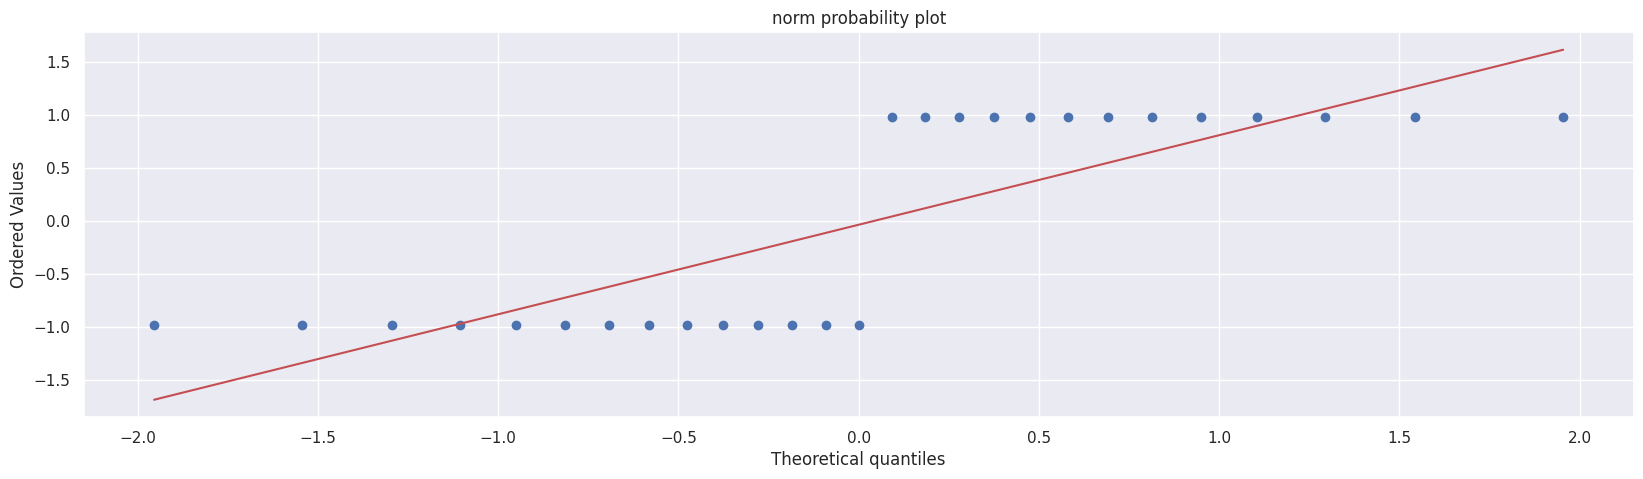

In [29]:
coplotti.plot_qq(single_asset_feature_df[feature])

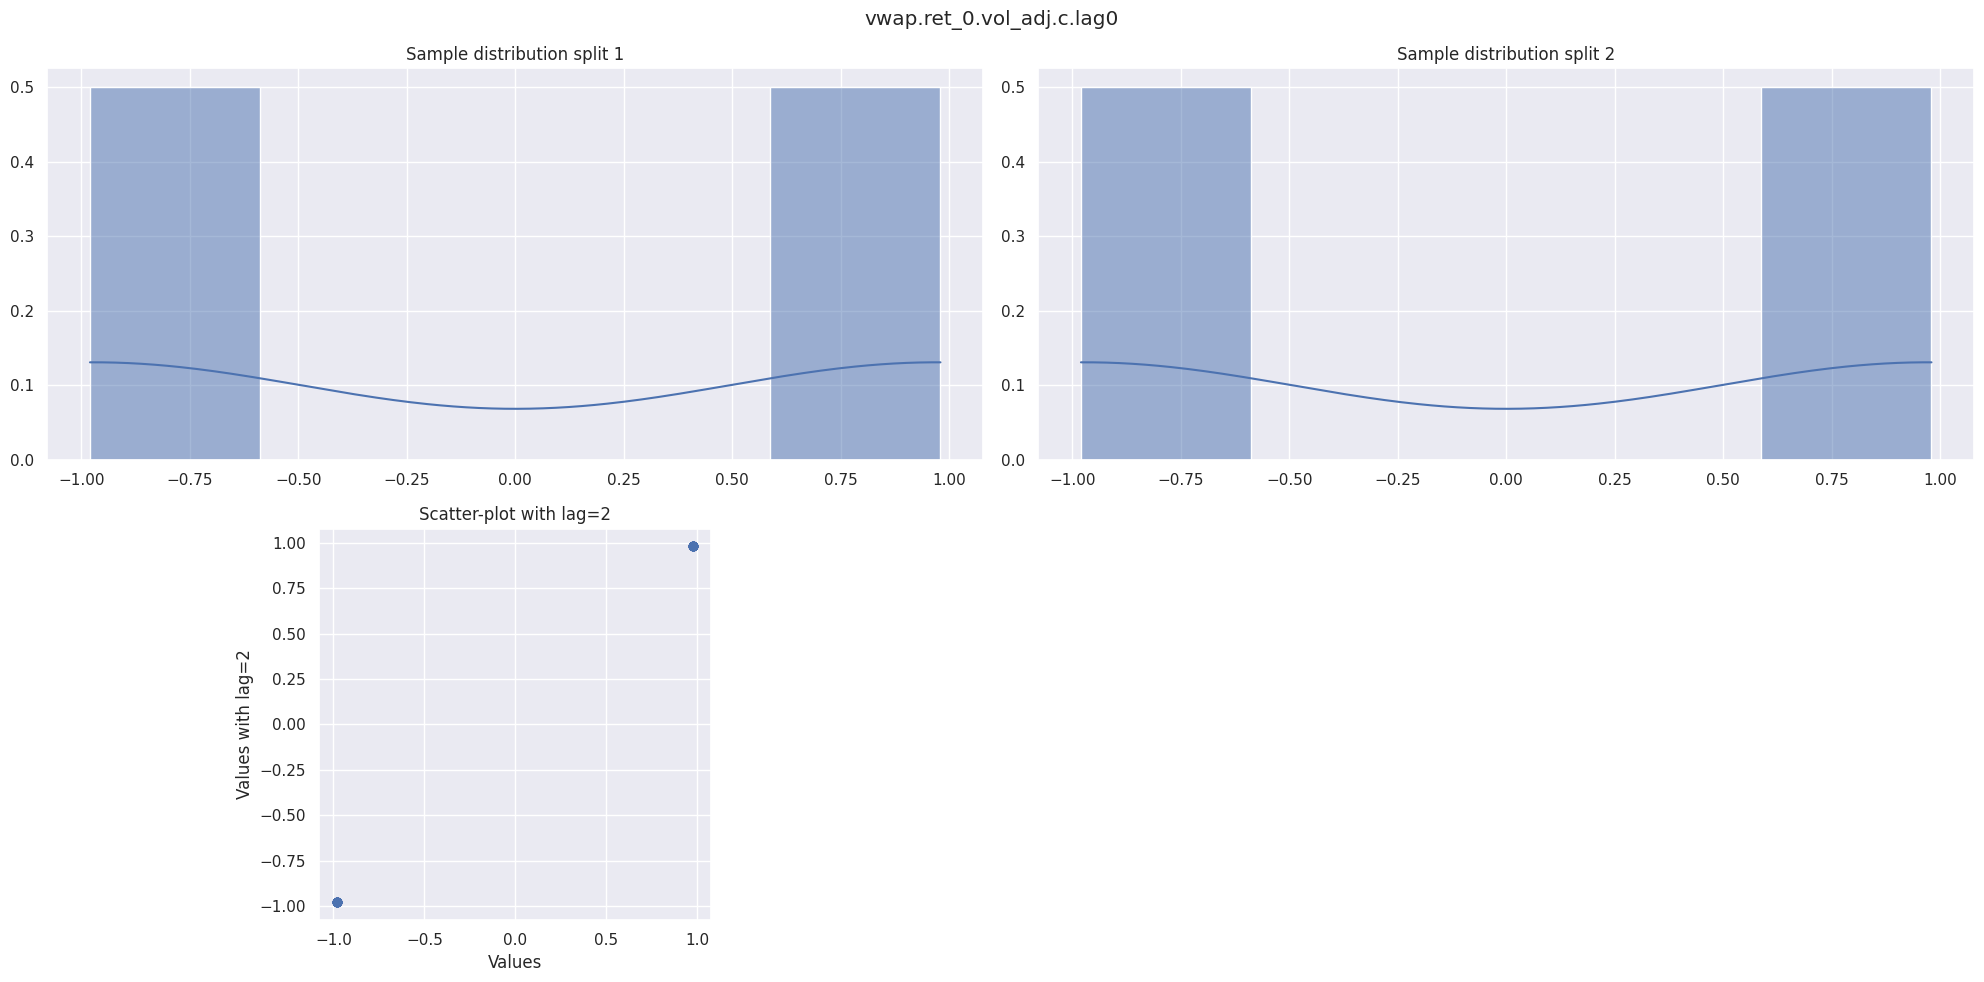

In [30]:
coplotti.plot_histograms_and_lagged_scatterplot(
    single_asset_feature_df[feature], lag=2, figsize=(20, 10)
)

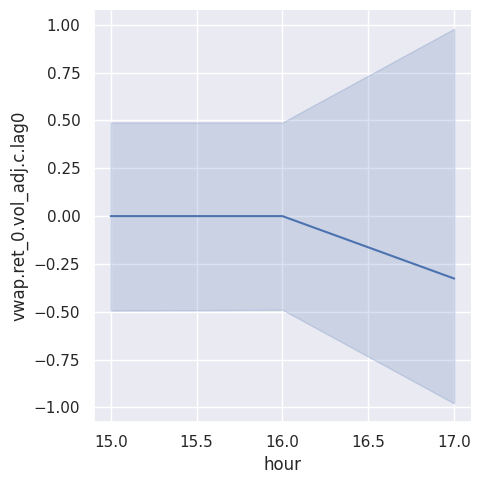

In [31]:
coplotti.plot_time_series_by_period(
    single_asset_feature_df[feature],
    "hour",
)

# Feature cross-section (single feature across all assets)

In [32]:
xs_feature_df = feature_df[feature]

asset_id,1467591036,3303714233
asset_id,,
1467591036,1.0,1.0
3303714233,1.0,1.0


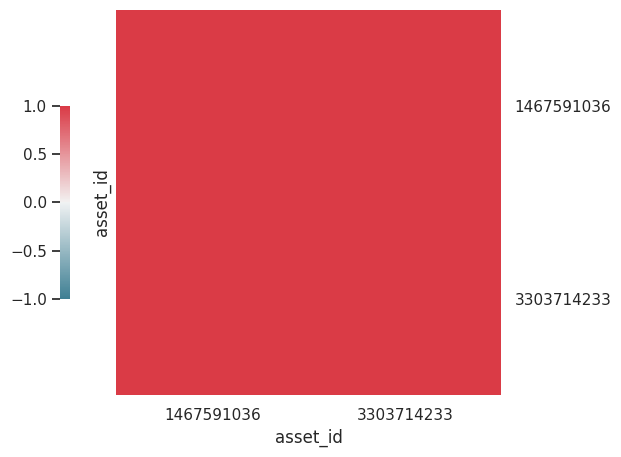

In [33]:
coplotti.plot_correlation_matrix(xs_feature_df)

/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[1.0, 1.0, 1.0]

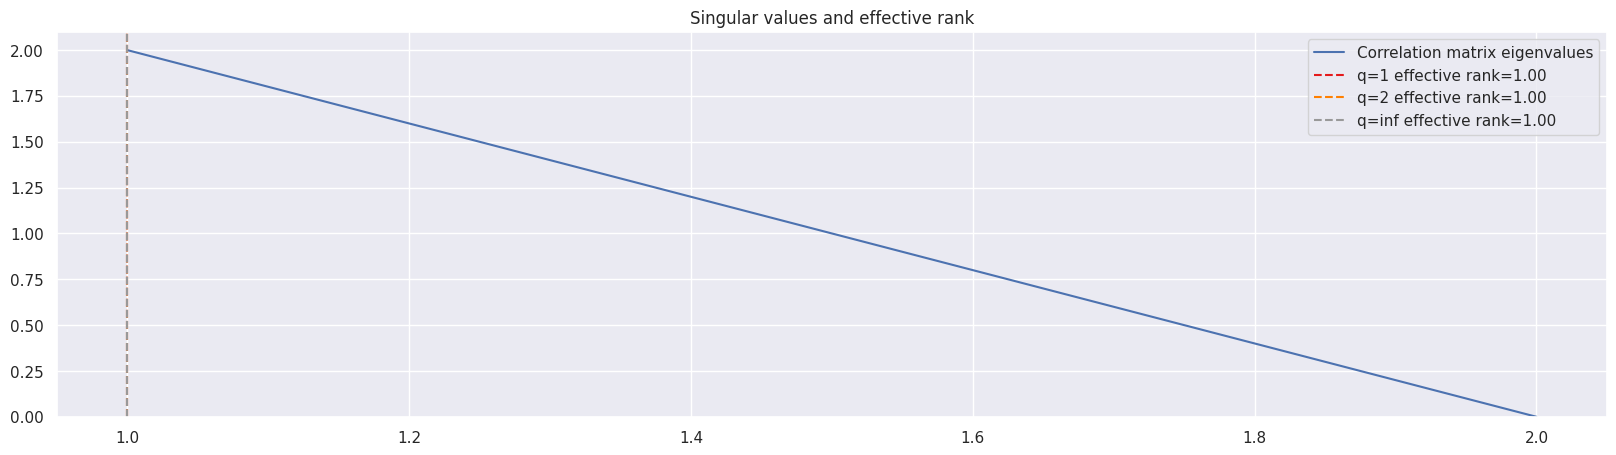

In [34]:
coplotti.plot_effective_correlation_rank(xs_feature_df)

# Linear regression

In [35]:
# NOTE: Discretion required to adapt and interpret.
regression_coeffs = costatis.compute_regression_coefficients_by_group(
    feature_df,
    **config["regression_config"].to_dict(),
)
display(regression_coeffs.head())

Processing groups:   0%|          | 0/2 [00:00<?, ?it/s]

count  eff_count          mean       var     covar  sgn_rho  rho  beta  SE(beta)  beta_z_scored      p_val_2s  autocovar  autocorr      turn
1467591036 vwap.ret_0.vol_adj.c.lag0     25       25.0 -3.918699e-02  0.959762  0.959762      1.0  1.0   1.0  0.200000       5.000000  5.733031e-07  -0.921372 -0.960000  1.979899
           vwap.ret_0.vol_adj.c.lag1     24       24.0  9.251859e-18  0.959762 -0.959762     -1.0 -1.0  -1.0  0.204124      -4.898979  9.633570e-07  -0.919772 -0.958333  1.979057
           vwap.ret_0.vol_adj.c.lag2     23       23.0 -4.259455e-02  0.959762  0.959762      1.0  1.0   1.0  0.208514       4.795832  1.620014e-06  -0.918034 -0.956522  1.978141
           vwap.ret_0.vol_adj.c.lag3     22       22.0  1.009294e-17  0.959762 -0.959762     -1.0 -1.0  -1.0  0.213201      -4.690416  2.726505e-06  -0.916137 -0.954545  1.977142
3303714233 vwap.ret_0.vol_adj.c.lag0     25       25.0 -3.918699e-02  0.959762  0.959762      1.0  1.0   1.0  0.200000       5.000000  5.733031e-07  -0.921372 -0.960000  1.979899

In [36]:
q_vals = costatis.estimate_q_values(regression_coeffs["p_val_2s"])
regression_coeffs["q_val"] = q_vals

<AxesSubplot: >

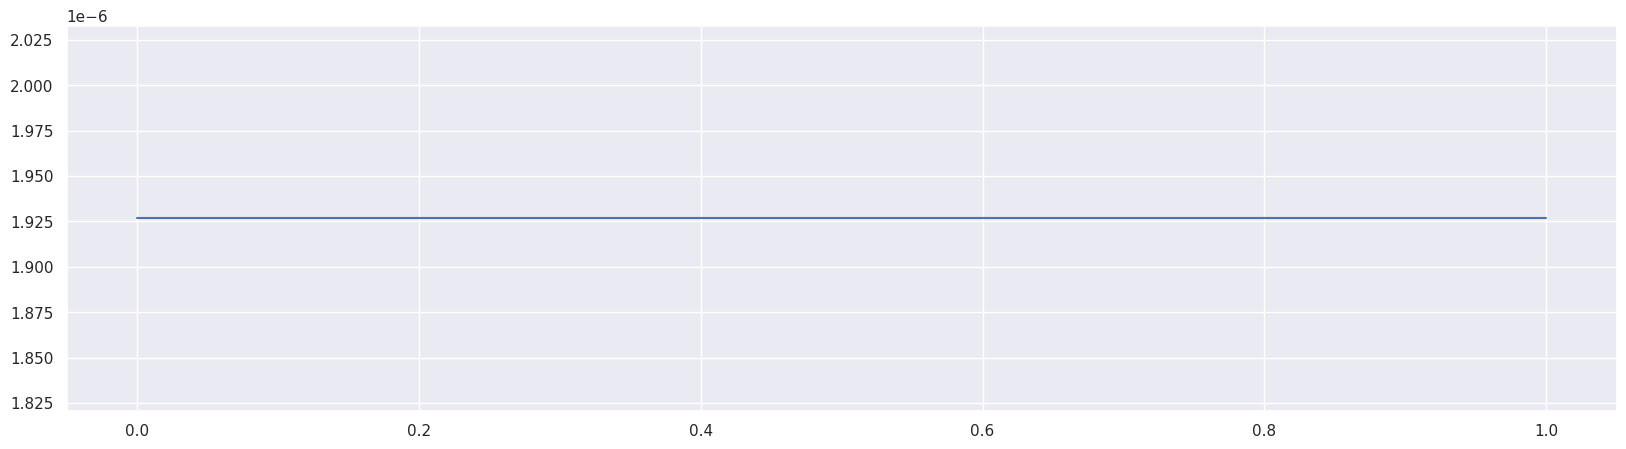

In [37]:
regression_coeffs["q_val"].xs(
    config["single_feature_column_name"], level=1
).sort_values().reset_index()["q_val"].plot()